In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files
import torch
import torchvision
import torchsummary
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.models as tm
import torchvision.datasets as datasets
from tqdm.notebook import tqdm
import warnings

warnings.filterwarnings('ignore')
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [46]:
from customDataset import PlantDataset
import os
import cv2

In [47]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download a file based on its file ID.
#
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
downloaded = drive.CreateFile({'id':'1wRX_cHhTCSEZytQVOSdPbPFwAWK-sNrA'})
print('Downloaded content "{}"'.format(downloaded.GetContentString()))

In [49]:
os.getcwd()

'/content/drive/My Drive/plants'

In [139]:
os.chdir('/content/drive/My Drive/plants/field')
datadir='/content/drive/My Drive/plants'
categories=os.listdir()[:100]
os.chdir(datadir)
os.listdir()

['field', 'resnet_0.2310.pth']

In [141]:
len(categories)

100

In [142]:
labels_list=[]
i=0
for c in categories:
  path=os.getcwd()+"/field/"+c
  class_num=categories.index(c)
  
  for im in os.listdir(path):
    lab=[]
    org=path+"/"+im
    lab.append(org)
    lab.append(class_num)
    labels_list.append(lab)    

In [144]:
len(labels_list)

3928

In [ ]:
data1=PlantDataset(labels_list,root_dir=None,transform=None)
data1

In [ ]:
len(data1)

In [148]:
train_data,test_data=torch.utils.data.random_split(data1,[3200,728])

In [ ]:
print(train_data.__len__())
print(test_data.__len__())

In [150]:
train_loader=DataLoader(dataset=train_data,batch_size=4,shuffle=True)
test_loader=DataLoader(dataset=test_data,batch_size=4,shuffle=False)


In [151]:
def show_imgs(imgs,title):
  imgs=imgs.cpu()
  mean=torch.tensor([0.485,0.456,0.406]).view(1,3,1,1)
  std=torch.tensor([0.229,0.224,0.225]).view(1,3,1,1)
  imgs = imgs * std + mean
  img_grid=torchvision.utils.make_grid(imgs,nrow=4)
  img_np=img_grid.numpy()
  img_np=np.transpose(img_np,(1,2,0))

  plt.figure(figsize=(8,4))
  plt.imshow(img_np)
  plt.title(title)
  plt.show()

training example
800


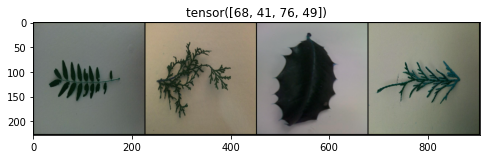

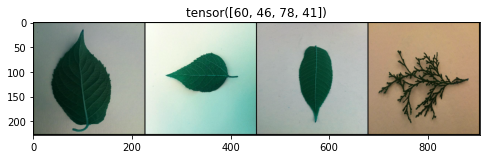

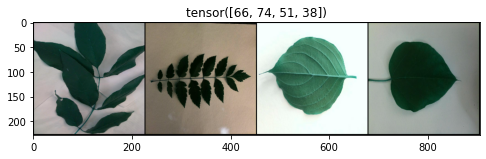

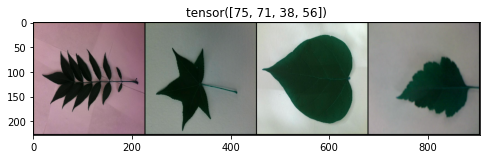

In [152]:
print("training example")
print(len(train_loader))
i=-1
for batch in train_loader:
  i+=1
  if i==4:
    break
  images,labels=batch
  
  # print(labels)
  show_imgs(images,labels)
  

In [153]:
resnet=tm.resnet18(pretrained=True)

In [ ]:
resnet

In [155]:
resnet.fc

Linear(in_features=512, out_features=1000, bias=True)

In [158]:
resnet.fc=nn.Linear(in_features=resnet.fc.in_features,out_features=100)

In [ ]:
resnet

In [160]:
for p in resnet.parameters():
  p.requires_grad=False

In [161]:
for p in resnet.fc.parameters():
  p.requires_grad=True

In [162]:
for p in resnet.parameters():
  if(p.requires_grad==True):
    print(p.size())

torch.Size([100, 512])
torch.Size([100])


In [163]:
def evaluate(model,dataloader):
  total,correct=0,0
  model.eval()
  for batch in dataloader:
    images,labels=batch
    images,labels=images.to(device),labels.to(device)

    outs=model(images)
    out_labels=torch.argmax(outs,axis=1)
    total+=labels.size(0)
    correct+=(labels==out_labels).sum().item()
  return 100*correct/total

In [164]:
#training with model checkpointing
import copy
def train(model,modelname,loss_fn,optimizer,train_loader,test_loader,epochs):
  hist={'epoch_loss':[],
        'train_acc':[],
        'test_acc':[]}
  min_loss=10000

  for epoch in tqdm(range(1,epochs+1),total=epochs,desc='training last layer'):
    losses=[]
    for batch in train_loader:
      images,labels=batch
      images,labels=images.to(device),labels.to(device)

      model.train()

      outs=model(images)
      loss=loss_fn(outs,labels)
      losses.append(loss.item())

      optimizer.zero_grad()
      loss.backward()

      optimizer.step()

      del images,labels,outs
      torch.cuda.empty_cache()
    
    curr_epoch_loss=np.array(losses).mean()
    hist['epoch_loss'].append(curr_epoch_loss)
    hist['train_acc'].append(evaluate(model,train_loader))
    hist['test_acc'].append(evaluate(model,test_loader))
    
    if curr_epoch_loss<min_loss:
      min_loss=curr_epoch_loss
      best_model=copy.deepcopy(model.state_dict())
  fig,ax=plt.subplots(ncols=2,figsize=(12,6))

  ax[0].plot(range(1,epochs+1),hist['epoch_loss'],label='Loss')
  ax[0].plot(range(1,epochs+1),np.ones(epochs)*min_loss,'r--',alpha=0.6,
             label='Min Loss={}'.format(min_loss))

  ax[0].set_xlabel('Epochs')
  ax[0].set_ylabel('Loss')
  ax[0].set_title("Epochs vs Loss")

  ax[0].grid()
  ax[0].legend()


  ax[1].plot(range(1,epochs+1),hist['train_acc'],'b--',alpha=0.8,label='Train accuracy')

  
  ax[1].plot(range(1,epochs+1),hist['test_acc'],'r--',alpha=0.8,label='Test accuracy')

  ax[1].set_xlabel('Epochs')
  ax[1].set_ylabel('Accuracy')
  ax[1].set_title("Epochs vs score")

  ax[1].grid()
  ax[1].legend()
  plt.plot()
  torch.save(best_model,'{0}_{1:.4f}.pth'.format(modelname,min_loss))
  print('Best loss value : {}'.format(min_loss))

  files.download('{0}_{1:.4f}.pth'.format(modelname,min_loss))

  return best_model


Best loss value : 0.3403840520523954


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

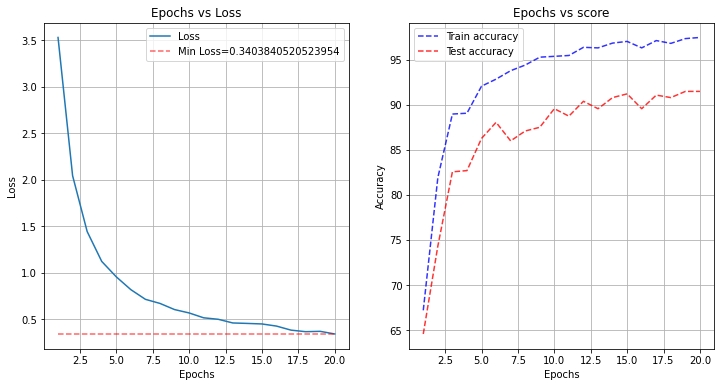

In [165]:
resnet=resnet.to(device)
opt=torch.optim.Adam(resnet.parameters(),lr=0.0005)
loss_fn=nn.CrossEntropyLoss()
resnet_wts=train(resnet,'resnet',loss_fn,opt,train_loader,test_loader,20)

In [ ]:
resnet_wts

In [ ]:
for i,j in test_loader:
  print(i)
  k=i
  k=k.to(device)
  p=resnet
  p.eval()
  x=p(k).detach()
  print(x)
  break

In [ ]:
cv2.imread(labels_list[0][0])

In [ ]:

model=resnet
model.load_state_dict(resnet_wts)
model.eval()
print(model)

In [168]:
test_transforms=transforms.Compose([
                                   transforms.ToTensor(),
                                   transforms.Normalize(mean=[0.485,0.456,0.406],
                                                        std=[0.229,0.224,0.225])
])

In [184]:

def predict_image(image):
    image_tensor = test_transforms(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input=image_tensor
    input = input.to(device)
    output = model(input)
    out_labels=torch.argmax(output)
    return out_labels

In [187]:
p=predict_image(cv2.imread(labels_list[2][0]))
print(categories[labels_list[2][1]])

acer_ginnala


In [188]:
categories[p]

'acer_campestre'